In [1]:
import pandas as pd
import glob
import os

# Set the folder path where your CSV files are stored
folder_path = 'data/output_poses_with_c'  # Adjust if your files are elsewhere

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Load and concatenate all CSV files into one DataFrame
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)  # Optionally add a column to track source
    df_list.append(df)

all_videos_df = pd.concat(df_list, ignore_index=True)

# Show the first few rows to confirm it worked
print(all_videos_df.head())

# Optionally, save combined DataFrame for later use
# all_videos_df.to_csv('/mnt/data/all_videos_combined.csv', index=False)


   FrameNo  head_x  head_y  head_confidence  left_shoulder_x  left_shoulder_y  \
0        0     995     389         0.557739             1059              450   
1        1     993     389         0.587303             1057              450   
2        2     990     389         0.598732             1057              450   
3        3     988     388         0.613654             1055              452   
4        4     988     388         0.622426             1056              452   

   left_shoulder_confidence  right_shoulder_x  right_shoulder_y  \
0                  0.560603               913               444   
1                  0.557815               913               444   
2                  0.565982               914               444   
3                  0.531750               913               443   
4                  0.534323               916               444   

   right_shoulder_confidence  ...  right_knee_x  right_knee_y  \
0                   0.464795  ...           9

In [18]:
"""
Lowest-confidence pose-sequence finder
• Optional middle-trim
• Full non-overlapping windows only
• Outputs original frame numbers *and* wall-clock time stamps
"""

import pandas as pd
import glob, os, math
from collections import defaultdict

# ─── USER SETTINGS ─────────────────────────────────────────────────────────────
folder_path     = "data/output_poses_with_c"   # where the *.csv live
fps             = 15            # frames per second in the original videos
window_size     = 15            # non-overlapping window size (frames)
list_length     = 200            # total sequences to list
max_per_video   = 1             # cap sequences per individual video
keep_frames     = 45            # keep this many middle frames (None → no trim)
conf_suffix     = "_confidence" # column-name suffix for confidences
# ───────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    """Convert decimal seconds to HH:MM:SS (zero-padded, no fractions)."""
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── Trim to middle `keep_frames` if requested ────────────────────────────
    if keep_frames and keep_frames < n_total:
        trim_left  = (n_total - keep_frames) // 2          # floor
        trim_right = n_total - keep_frames - trim_left     # may be +1
        df_trimmed = df.iloc[trim_left : n_total - trim_right].reset_index(drop=True)
    else:
        trim_left  = 0
        df_trimmed = df.copy()

    n_frames = len(df_trimmed)

    # Identify confidence columns
    conf_cols = [c for c in df_trimmed.columns if c.lower().endswith(conf_suffix)]
    if not conf_cols:
        raise ValueError(f"No “{conf_suffix}” columns in {filename}")

    # ── Iterate through *full* non-overlapping windows ───────────────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        start_trim = w * window_size               # 0-based in trimmed clip
        end_trim   = start_trim + window_size      # exclusive
        window     = df_trimmed.iloc[start_trim:end_trim]

        means       = window[conf_cols].mean()
        worst_col   = means.idxmin()
        worst_joint = worst_col.replace(conf_suffix, "")
        worst_val   = means[worst_col]

        # Translate to original frame indices (1-based, inclusive)
        orig_start = trim_left + start_trim + 1
        orig_end   = trim_left + end_trim          # inclusive

        all_windows.append(
            {
                "filename":     filename,
                "orig_start":   orig_start,
                "orig_end":     orig_end,
                "joint":        worst_joint,
                "avg_conf":     worst_val,
                "t_start":      (orig_start - 1) / fps,
                "t_end":        (orig_end   - 1) / fps,
            }
        )

# ─── Global ranking & output limits ───────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])          # worst first
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── Report ───────────────────────────────────────────────────────────────────
print("\nWorst sequences found (original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– confidence of the {w['joint']} is {w['avg_conf']:.2f}"
    )



Worst sequences found (original timeline):

W25.csv  frames 108–122  from 00:00:07 to 00:00:08  – confidence of the left_foot is 0.13
W31.csv  frames 105–119  from 00:00:07 to 00:00:08  – confidence of the right_foot is 0.14
W24.csv  frames 100–114  from 00:00:07 to 00:00:08  – confidence of the left_knee is 0.15
W34.csv  frames 103–117  from 00:00:07 to 00:00:08  – confidence of the left_foot is 0.16
W09.csv  frames 102–116  from 00:00:07 to 00:00:08  – confidence of the right_foot is 0.16
G73.csv  frames 156–170  from 00:00:10 to 00:00:11  – confidence of the right_hand is 0.17
G04.csv  frames 118–132  from 00:00:08 to 00:00:09  – confidence of the right_hand is 0.17
G38.csv  frames 127–141  from 00:00:08 to 00:00:09  – confidence of the right_elbow is 0.17
G28.csv  frames 99–113  from 00:00:07 to 00:00:07  – confidence of the right_hand is 0.17
G05.csv  frames 102–116  from 00:00:07 to 00:00:08  – confidence of the right_hand is 0.18
W18.csv  frames 101–115  from 00:00:07 to 00:00:

In [17]:
"""
Highest-confidence pose-sequence finder
• Optional middle-trim
• Full non-overlapping windows only
• Reports original frame numbers and wall-clock time stamps
• NOW: shows the joint with the HIGHEST confidence in each window
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path     = "data/output_poses_with_c"   # where the *.csv live
fps             = 15            # frames per second in the original videos
window_size     = 10            # non-overlapping window size (frames)
list_length     = 200           # total sequences to list
max_per_video   = 1             # cap sequences per individual video
keep_frames     = 40            # keep this many middle frames (None → no trim)
conf_suffix     = "_confidence" # column-name suffix for confidences
# ──────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    """Convert decimal seconds to HH:MM:SS."""
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── Trim to the middle `keep_frames` frames if requested ────────────────
    if keep_frames and keep_frames < n_total:
        trim_left  = (n_total - keep_frames) // 2
        trim_right = n_total - keep_frames - trim_left
        df_trimmed = df.iloc[trim_left : n_total - trim_right].reset_index(drop=True)
    else:
        trim_left  = 0
        df_trimmed = df.copy()

    n_frames   = len(df_trimmed)
    conf_cols  = [c for c in df_trimmed.columns if c.lower().endswith(conf_suffix)]
    if not conf_cols:
        raise ValueError(f"No “{conf_suffix}” columns in {filename}")

    # ── Full, non-overlapping windows ───────────────────────────────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        start_t   = w * window_size
        end_t     = start_t + window_size
        window    = df_trimmed.iloc[start_t:end_t]

        means       = window[conf_cols].mean()
        best_col    = means.idxmax()               # ← change 1 (idxmax, not idxmin)
        best_joint  = best_col.replace(conf_suffix, "")
        best_val    = means[best_col]              # highest = best

        orig_start  = trim_left + start_t + 1      # 1-based inclusive
        orig_end    = trim_left + end_t

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "joint":      best_joint,
                "avg_conf":   best_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── Rank by *highest* joint confidence ──────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"], reverse=True)  # ← change 2
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── Report ──────────────────────────────────────────────────────────────────
print("\nBest sequences found (original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– confidence of the {w['joint']} is {w['avg_conf']:.2f}"
    )



Best sequences found (original timeline):

W08.csv  frames 107–116  from 00:00:07 to 00:00:08  – confidence of the right_hip is 0.79
W29.csv  frames 113–122  from 00:00:07 to 00:00:08  – confidence of the left_hip is 0.75
W06.csv  frames 86–95  from 00:00:06 to 00:00:06  – confidence of the right_shoulder is 0.74
W37.csv  frames 70–79  from 00:00:05 to 00:00:05  – confidence of the left_hip is 0.74
W20.csv  frames 65–74  from 00:00:04 to 00:00:05  – confidence of the right_knee is 0.74
W07.csv  frames 79–88  from 00:00:05 to 00:00:06  – confidence of the right_shoulder is 0.74
G71.csv  frames 239–248  from 00:00:16 to 00:00:16  – confidence of the right_hip is 0.73
W19.csv  frames 60–69  from 00:00:04 to 00:00:05  – confidence of the left_hip is 0.73
G28.csv  frames 92–101  from 00:00:06 to 00:00:07  – confidence of the right_knee is 0.72
G72.csv  frames 261–270  from 00:00:17 to 00:00:18  – confidence of the right_hip is 0.72
W42.csv  frames 95–104  from 00:00:06 to 00:00:07  – confi

FrameNo,
left_shoulder,left_elbow,left_hand, left_hip,left_knee,left_foot,
right_shoulder,right_elbow,right_hand, right_hip,right_knee,right_foot,








Worst sequences found (block averages, original timeline):

G52.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.31
G53.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.34
G25.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.35
G31.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.35
G55.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.35
G05.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.35
W17.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.36
G03.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.39
G41.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.40
G40.csv  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.40
W03.csv  frames 1–30  from 00

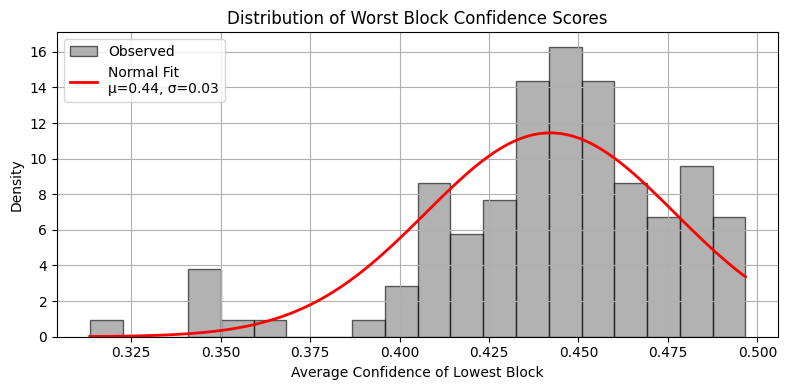


Saved 114 rows to convedence_30.csv



In [2]:
"""
Lowest-confidence pose-sequence finder  (block version)
• Optional middle-trim
• Full non-overlapping windows
• Works with four body blocks (head excluded)
• Reports original frame numbers & hh:mm:ss timeline
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/output_poses_with_c"  # where the CSVs live
fps           = 15        # frames per second
window_size   = 30        # frames per window (non-overlapping)
list_length   = 5000       # total windows to list
max_per_video = 6         # cap windows per individual video
keep_frames   = 30        # keep this many middle frames (None → no trim)
conf_suffix   = "_confidence"
# ──────────────────────────────────────────────────────────────────────────────

# Map block label → list of confidence column names
BLOCKS = {
    "top_left":    ["left_shoulder_confidence",  "left_elbow_confidence",
                    "left_hand_confidence"],
    "bottom_left": ["left_hip_confidence",       "left_knee_confidence",
                    "left_foot_confidence"],
    "top_right":   ["right_shoulder_confidence", "right_elbow_confidence",
                    "right_hand_confidence"],
    "bottom_right":["right_hip_confidence",      "right_knee_confidence",
                    "right_foot_confidence"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── choose the FIRST `keep_frames` frames (no middle-trim any more) ───────────
    if keep_frames and keep_frames < n_total:
        df_trim   = df.iloc[:keep_frames].reset_index(drop=True)   # first X frames
    else:
        df_trim   = df.copy()                                      # use whole clip
    cut_left = 0       # always zero now, because we never trim from the start





    n_frames = len(df_trim)
    # quick sanity: make sure every required column is present
    for cols in BLOCKS.values():
        missing = [c for c in cols if c not in df_trim.columns]
        if missing:
            raise ValueError(f"{filename} lacks columns: {missing}")

    # ── full, non-overlapping windows ───────────────────────────────────────
    for w in range(n_frames // window_size):
        s  = w * window_size
        e  = s + window_size     # exclusive
        win = df_trim.iloc[s:e]

        # block averages for this window
        block_avg = {
            label: win[cols].mean().mean()     # mean over frames then joints
            for label, cols in BLOCKS.items()
        }

        worst_label = min(block_avg, key=block_avg.get)
        worst_val   = block_avg[worst_label]

        orig_start = cut_left + s + 1     # 1-based inclusive
        orig_end   = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "avg_conf":   worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])  # smallest first  (worst)
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nWorst sequences found (block averages, original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} average confidence {w['avg_conf']:.2f}"
    )
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract confidence scores from the selected windows
confidences = [w["avg_conf"] for w in selected]

# Fit a normal distribution
mu, std = norm.fit(confidences)

# Generate x-values across the range
x = np.linspace(min(confidences), max(confidences), 100)
pdf = norm.pdf(x, mu, std)

# Plot histogram and fitted normal curve
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed')
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
plt.title("Distribution of Worst Block Confidence Scores")
plt.xlabel("Average Confidence of Lowest Block")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    # add hh:mm:ss strings for convenience
    out["t_start_hms"] = out["t_start"].apply(fmt_time)
    out["t_end_hms"]   = out["t_end"].apply(fmt_time)

    output_fname = f"convedence_{window_size}.csv"
    out.to_csv(output_fname, index=False)
    print(f"\nSaved {len(out)} rows to {output_fname}\n")
else:
    print("\nNo windows met the selection criteria – nothing saved.\n")


In [1]:
import pandas as pd
import glob, os

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/output_poses_with_c"   # where the *.csv files live
conf_suffix   = "_confidence"                # column name pattern
exclude_cols  = {"head_confidence"}          # joints you don’t want to count
out_csv       = "aggregated_confidence.csv"  # result file
# ──────────────────────────────────────────────────────────────────────────────

records = []

for path in glob.glob(os.path.join(folder_path, "*.csv")):
    df       = pd.read_csv(path)
    filename = os.path.basename(path)

    # pick every *_confidence column except excluded ones
    conf_cols = [c for c in df.columns
                 if c.lower().endswith(conf_suffix) and c not in exclude_cols]

    if not conf_cols:
        print(f"⚠️  {filename}: no matching confidence columns – skipped.")
        continue

    avg_conf = df[conf_cols].mean().mean()   # mean over frames, then joints
    records.append({"filename": filename, "avg_confidence": avg_conf})

# turn into DataFrame, sort (lowest = “worst”), and save
summary = pd.DataFrame(records).sort_values("avg_confidence")
summary.to_csv(out_csv, index=False)
print(f"Saved aggregated scores for {len(summary)} videos to '{out_csv}'.")
print(summary.head())        # quick peek at the worst few videos


Saved aggregated scores for 114 videos to 'aggregated_confidence.csv'.
    filename  avg_confidence
106  W36.csv        0.386970
98   W28.csv        0.419091
104  W34.csv        0.420246
110  W40.csv        0.429407
101  W31.csv        0.431772



Worst sequences found (block averages, original timeline):

W34.csv  frames 95–104  from 00:00:06 to 00:00:07  – block bottom_right average confidence 0.18
W21.csv  frames 59–68  from 00:00:04 to 00:00:04  – block bottom_right average confidence 0.23
W28.csv  frames 47–56  from 00:00:03 to 00:00:04  – block bottom_left average confidence 0.23
W31.csv  frames 107–116  from 00:00:07 to 00:00:08  – block bottom_right average confidence 0.25
W28.csv  frames 57–66  from 00:00:04 to 00:00:04  – block bottom_left average confidence 0.25
W36.csv  frames 111–120  from 00:00:07 to 00:00:08  – block bottom_left average confidence 0.25
W36.csv  frames 121–130  from 00:00:08 to 00:00:09  – block top_left average confidence 0.25
W34.csv  frames 105–114  from 00:00:07 to 00:00:08  – block bottom_right average confidence 0.25
W36.csv  frames 91–100  from 00:00:06 to 00:00:07  – block bottom_left average confidence 0.25
W36.csv  frames 101–110  from 00:00:07 to 00:00:07  – block bottom_right average c

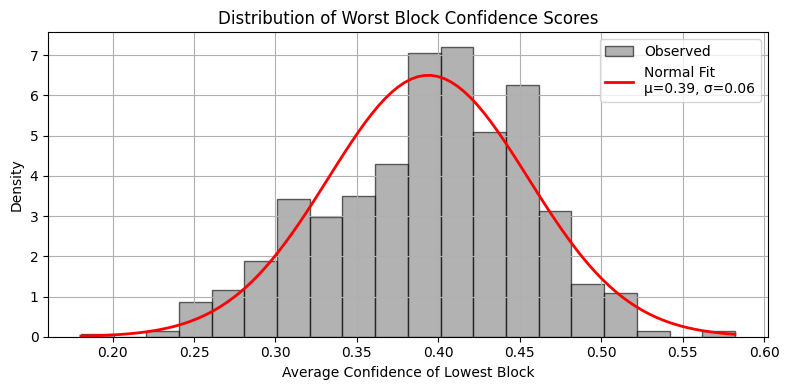


Saved 684 rows to convedence_10.csv



In [2]:
"""
Lowest-confidence pose-sequence finder  (block version)
• Optional middle-trim
• Full non-overlapping windows
• Works with four body blocks (head excluded)
• Reports original frame numbers & hh:mm:ss timeline
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/output_poses_with_c"  # where the CSVs live
fps           = 15        # frames per second
window_size   = 10        # frames per window (non-overlapping)
list_length   = 5000       # total windows to list
max_per_video = 6         # cap windows per individual video
keep_frames   = 60        # keep this many middle frames (None → no trim)
conf_suffix   = "_confidence"
# ──────────────────────────────────────────────────────────────────────────────

# Map block label → list of confidence column names
BLOCKS = {
    "top_left":    ["left_shoulder_confidence",  "left_elbow_confidence",
                    "left_hand_confidence"],
    "bottom_left": ["left_hip_confidence",       "left_knee_confidence",
                    "left_foot_confidence"],
    "top_right":   ["right_shoulder_confidence", "right_elbow_confidence",
                    "right_hand_confidence"],
    "bottom_right":["right_hip_confidence",      "right_knee_confidence",
                    "right_foot_confidence"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── optional middle trim ────────────────────────────────────────────────
    if keep_frames and keep_frames < n_total:
        cut_left  = (n_total - keep_frames) // 2
        cut_right = n_total - keep_frames - cut_left
        df_trim   = df.iloc[cut_left : n_total - cut_right].reset_index(drop=True)
    else:
        cut_left  = 0
        df_trim   = df.copy()

    n_frames = len(df_trim)
    # quick sanity: make sure every required column is present
    for cols in BLOCKS.values():
        missing = [c for c in cols if c not in df_trim.columns]
        if missing:
            raise ValueError(f"{filename} lacks columns: {missing}")

    # ── full, non-overlapping windows ───────────────────────────────────────
    for w in range(n_frames // window_size):
        s  = w * window_size
        e  = s + window_size     # exclusive
        win = df_trim.iloc[s:e]

        # block averages for this window
        block_avg = {
            label: win[cols].mean().mean()     # mean over frames then joints
            for label, cols in BLOCKS.items()
        }

        worst_label = min(block_avg, key=block_avg.get)
        worst_val   = block_avg[worst_label]

        orig_start = cut_left + s + 1     # 1-based inclusive
        orig_end   = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "avg_conf":   worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])  # smallest first  (worst)
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nWorst sequences found (block averages, original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} average confidence {w['avg_conf']:.2f}"
    )
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract confidence scores from the selected windows
confidences = [w["avg_conf"] for w in selected]

# Fit a normal distribution
mu, std = norm.fit(confidences)

# Generate x-values across the range
x = np.linspace(min(confidences), max(confidences), 100)
pdf = norm.pdf(x, mu, std)

# Plot histogram and fitted normal curve
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed')
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
plt.title("Distribution of Worst Block Confidence Scores")
plt.xlabel("Average Confidence of Lowest Block")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    # add hh:mm:ss strings for convenience
    out["t_start_hms"] = out["t_start"].apply(fmt_time)
    out["t_end_hms"]   = out["t_end"].apply(fmt_time)

    output_fname = f"convedence_{window_size}.csv"
    out.to_csv(output_fname, index=False)
    print(f"\nSaved {len(out)} rows to {output_fname}\n")
else:
    print("\nNo windows met the selection criteria – nothing saved.\n")


Most-jittery sequences found:

G68.csv  frames 80–94  from 00:00:05 to 00:00:06  – block top_right total displacement 3885.8 units
W07.csv  frames 81–95  from 00:00:05 to 00:00:06  – block bottom_left total displacement 3776.7 units
W17.csv  frames 49–63  from 00:00:03 to 00:00:04  – block top_right total displacement 3720.1 units
W19.csv  frames 38–52  from 00:00:02 to 00:00:03  – block top_right total displacement 3180.8 units
W38.csv  frames 75–89  from 00:00:05 to 00:00:06  – block top_right total displacement 2813.0 units
W28.csv  frames 54–68  from 00:00:04 to 00:00:04  – block bottom_left total displacement 2450.2 units
W40.csv  frames 121–135  from 00:00:08 to 00:00:09  – block top_right total displacement 2415.6 units
W05.csv  frames 143–157  from 00:00:09 to 00:00:10  – block top_right total displacement 2190.1 units
W34.csv  frames 103–117  from 00:00:07 to 00:00:08  – block bottom_left total displacement 2114.3 units
W25.csv  frames 108–122  from 00:00:07 to 00:00:08  – bl

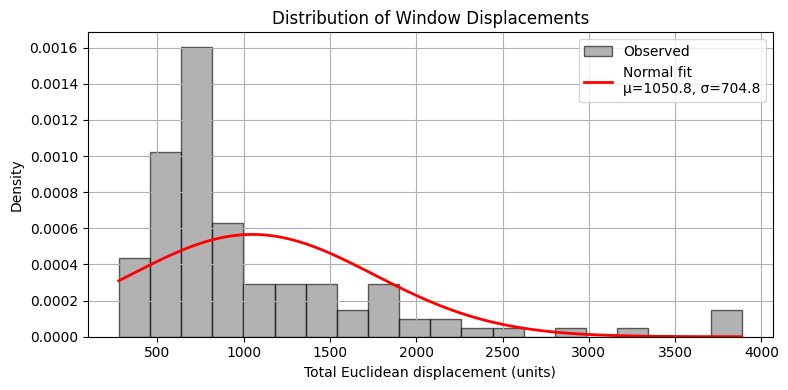


Saved 114 rows to 'motion_15.csv'.


In [5]:
"""
Most-jittery pose-sequence finder  (4-block version)
• Keeps only the middle `keep_frames` frames of every clip (optional)
• Splits those frames into full, non-overlapping windows
• For each window, measures total x-y displacement inside each of the
  four body blocks (head excluded)
• Ranks windows by the **largest** block displacement (i.e. most “stutter”)
• Reports timeline info, plots the displacement distribution, and
  saves the results to CSV
"""

import pandas as pd
import numpy as np
import glob, os
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import norm

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/output_poses_with_c"   # where the CSV files live
fps           = 15        # frames per second in the original videos
window_size   = 15        # frames per window (non-overlapping)
list_length   = 200       # total windows to list
max_per_video = 1         # cap sequences per individual video
keep_frames   = 45        # keep this many middle frames (None → no trim)
out_csv_name  = f"motion_{window_size}.csv"  # output file name
# ──────────────────────────────────────────────────────────────────────────────

# Four body blocks (no head)
BLOCKS = {
    "top_left":    ["left_shoulder",  "left_elbow",  "left_hand"],
    "bottom_left": ["left_hip",       "left_knee",   "left_foot"],
    "top_right":   ["right_shoulder", "right_elbow", "right_hand"],
    "bottom_right":["right_hip",      "right_knee",  "right_foot"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

# ─── iterate through every video CSV ──────────────────────────────────────────
for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── keep the middle `keep_frames` frames if requested ────────────────────
    if keep_frames and keep_frames < n_total:
        cut_left  = (n_total - keep_frames) // 2
        cut_right = n_total - keep_frames - cut_left
        df_trim   = df.iloc[cut_left : n_total - cut_right].reset_index(drop=True)
    else:
        cut_left  = 0
        df_trim   = df.copy()

    n_frames = len(df_trim)

    # ── full, non-overlapping windows ranked by motion “jitter” ──────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        s, e = w * window_size, (w + 1) * window_size      # [s, e)
        win  = df_trim.iloc[s:e]

        block_disp = {}
        for label, joints in BLOCKS.items():
            xy_cols = []
            for j in joints:
                xy_cols.extend([f"{j}_x", f"{j}_y"])

            # Ensure columns exist
            missing = [c for c in xy_cols if c not in win.columns]
            if missing:
                raise ValueError(f"{filename} is missing columns: {missing}")

            # frame-to-frame deltas
            diffs = win[xy_cols].diff().iloc[1:]            # drop first NaN
            if diffs.empty:
                continue
            arr   = diffs.to_numpy().reshape(len(diffs), -1, 2)  # (F-1, J, 2)
            dist  = np.linalg.norm(arr, axis=2)             # Euclidean per joint/frame
            block_disp[label] = dist.sum()                  # scalar displacement

        # find block with max displacement (= most jitter)
        worst_label = max(block_disp, key=block_disp.get)
        worst_val   = block_disp[worst_label]

        orig_start  = cut_left + s + 1     # 1-based inclusive
        orig_end    = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "motion":     worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["motion"], reverse=True)   # largest first
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nMost-jittery sequences found:\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} total displacement {w['motion']:.1f} units"
    )

# ─── distribution plot ───────────────────────────────────────────────────────
if selected:
    motions = [w["motion"] for w in selected]
    mu, std = norm.fit(motions)
    xs      = np.linspace(min(motions), max(motions), 100)
    pdf     = norm.pdf(xs, mu, std)

    plt.figure(figsize=(8, 4))
    plt.hist(motions, bins=20, density=True, alpha=0.6,
             color='gray', edgecolor='black', label='Observed')
    plt.plot(xs, pdf, 'r-', linewidth=2,
             label=f'Normal fit\nμ={mu:.1f}, σ={std:.1f}')
    plt.title("Distribution of Window Displacements")
    plt.xlabel("Total Euclidean displacement (units)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    out["t_start_hms"] = out["t_start"].apply(fmt_time)
    out["t_end_hms"]   = out["t_end"].apply(fmt_time)
    out.to_csv(out_csv_name, index=False)
    print(f"\nSaved {len(out)} rows to '{out_csv_name}'.")
else:
    print("\nNo windows met the selection criteria – nothing saved.")
